# This is the code for our research regarding a semantic analysis of SDGs and UN reports.

To overwrite all existing and interferring files we first clean all variables in Python: (only relevant working 
in Spyder - Anaconda environment):

In [4]:
def clear_all():
    gl = globals().copy()
    for var in gl:
        if var[0] == '_': continue
        if 'func' in str(globals()[var]): continue
        if 'module' in str(globals()[var]): continue

        del globals()[var]
if __name__ == "__main__":
    clear_all()

We first start by importing the necessary packages:

In [1]:
import pandas as pd
import numpy as np
import sys

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en.examples import sentences

from html.parser import HTMLParser
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from string import punctuation
from collections import Counter
import mpld3

from collections import OrderedDict
import re
import warnings
import itertools as it



from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist

To suppress some of the (harmless) warnings:

In [ ]:
warnings.filterwarnings("ignore", category=DeprecationWarning)

Now we import stopwords. They suppress noise from text data, 
such that words like "the", "and", "a", etc. are ignored for tokenizing.

In [40]:
porter = PorterStemmer()
wnl = WordNetLemmatizer()
stop = stopwords.words('english')
stop.append("new")
stop.append("like")
stop.append("u")
stop.append("it'")
stop.append("'s")
stop.append("n't")
stop.append('mr.')
stop = set(stop)

We can start to load in the data from excel now. While loading it in we replace all 'x' with 1 and 0 otherwise.
Note that we import SDG, targets and indicators respectively so we can merge them or not. 

In [2]:
#import first sheet: SDG Goals
sdg = pd.read_excel('sdg.xlsx', header=None, encoding='latin', skip_blank_lines=False)
sdg.fillna(0, inplace=True)
sdg = sdg.where(sdg != "x", 1)
sdg = sdg.where(sdg != "X", 1)

#import second sheet: SDG Targets
target = pd.read_excel('Target.xlsx', header=None, encoding='latin', skip_blank_lines=False)
target.fillna(0, inplace=True)
target = target.where(target != "x", 1)
target = target.where(target != "X", 1)

#import third sheet: SDG Indicators
indicator = pd.read_excel('Indicator.xlsx', header=None, encoding='latin', skip_blank_lines=False)
indicator.fillna(0, inplace=True)
indicator = indicator.where(indicator != "x", 1)
indicator = indicator.where(indicator != "X", 1)

In [6]:
sdg.head()

,0,1,2,3,4,5,6,7,8,9,...,1306,1307,1308,1309,1310,1311,1312,1313,1314,1315
0,Goal,Description,The future we want,10-Year Framework of Programmes on Sustainable...,10-Year Framework of Programmes on Sustainable...,abuse,access,access rights,access to affordable essential medicines and v...,access to banking,...,World Heritage Centre designation,World Trade Organization,World Trade Organization agreements,yield,young,young people,youth,youth (aged 15–24 years),youth employment,zero-tariff
1,1,End poverty in all its forms everywhere,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,"End hunger, achieve food security and improved...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,Ensure healthy lives and promote well-being fo...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,Ensure inclusive and equitable quality educati...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now we obtain an array of the keywords

In [ ]:
keys = sdg.iloc[0,2:1317] #could have used targets to obtain keys
keys = keys.astype(str)
keys = keys.reset_index()
keys = keys.drop(['index'], axis=1)
#decapitalize keywords for better matching
a = keys[0].tolist()
a = [element.lower() for element in a]
strip = pd.DataFrame({0:a})

#because indicator has one key word more we use also the indicator keywords.
keys2 = indicator.iloc[0,4:1319]
keys2 = keys2.astype(str)
keys2 = keys2.reset_index()
keys2 = keys2.drop(['index'], axis=1)
#decapitalize:
a = keys[0].tolist()
a = [element.lower() for element in a]
strip2 = pd.DataFrame({0:a})

In [5]:
strip2.head()

,0
0,the future we want
1,10-year framework of programmes on sustainable...
2,10-year framework of programmes on sustainable...
3,abuse
4,access


The next step puts and decapitalize the text data for SDGs, targets and indicators in single dataframes:

In [9]:
#Goals:
sdg.columns = sdg.iloc[0]
goals = sdg.iloc[1:18,0:2]
goals = goals.astype(str)
goals = goals.reset_index()
goals = goals.drop(['index'], axis=1)

#decapitalize goals for better matching
a = goals['Description'].tolist()
a = [element.lower() for element in a]
goals_lower = pd.DataFrame({'Description':a})
del goals['Description']
frames = [goals, goals_lower]
goals = pd.concat(frames, axis=1)

#Targets:
target.columns = target.iloc[0]
targets = target.iloc[1:170,0:3]
targets = targets.astype(str)
targets = targets.reset_index()
targets = targets.drop(['index'], axis=1)

#decapitalize targets for better matching
a = targets['Description'].tolist()
a = [element.lower() for element in a]
target_lower = pd.DataFrame({'Description':a})
del targets['Description']
frames = [targets, target_lower]
targets = pd.concat(frames, axis=1)

#Indicators:
indicator.columns = indicator.iloc[0]
indicators = indicator.iloc[1:246,0:4]
indicators = indicators.astype(str)
indicators = indicators.reset_index()
indicators = indicators.drop(['index'], axis=1)

#decapitalize indicators for better matching
a = indicators['Description'].tolist()
a = [element.lower() for element in a]
indicator_lower = pd.DataFrame({'Description':a})
del indicators['Description']
frames = [indicators, indicator_lower]
indicators = pd.concat(frames, axis=1)

In [18]:
goals.head()

,Goal,Description
0,1,end poverty in all its forms everywhere
1,2,"end hunger, achieve food security and improved..."
2,3,ensure healthy lives and promote well-being fo...
3,4,ensure inclusive and equitable quality educati...
4,5,achieve gender equality and empower all women ...


In [16]:
targets.head()

,Goal,Target,Description
0,1,1.1,"by 2030, eradicate extreme poverty for all peo..."
1,1,1.2,"by 2030, reduce at least by half the proportio..."
2,1,1.3,implement nationally appropriate social protec...
3,1,1.4,"by 2030, ensure that all men and women, in par..."
4,1,1.5,"by 2030, build the resilience of the poor and ..."


In [17]:
indicators.head()

,Goal,Target,Indicator,Description
0,1,1.1,1.1.1,proportion of population below the internation...
1,1,1.2,1.2.1,proportion of population living below the nati...
2,1,1.2,1.2.2,proportion of population living below the nati...
3,1,1.3,1.3.1,proportion of population covered by social pro...
4,1,1.4,1.4.1,proportion of population living in households ...


This is the first approach: Combinging all, SDGs with their targets and indictors to obtain 17 "documents" with the data:

In [19]:
#group by goals and sum up string in targets and indicators
target_sum = targets.groupby(['Goal'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ' '.join(x))
indicator_sum = indicators.groupby(['Goal'],as_index=False).agg(lambda x : x.sum() if x.dtype=='float64' else ' '.join(x))

goals['target'] = target_sum['Description']
goals['indicator'] = indicator_sum['Description']
#rename SDG
goals = goals.rename(index=str, columns={'Descript6ion' : "SDG"})
goals['total']= goals.stack().groupby(level=0).apply(', '.join)

Now that we loaded in the data as desired, we have to apply the stopwords and tokenize it for the eventual analysis.
For this we set up several functions that run over the data and return a pandas dataframe with also the top keywords
by count:

In [24]:
#This function is set up only for Python 3. To run it in Python 2 some minor changes have to be made. 
def tokenizer(text):
    tokens_ = [word_tokenize(sent) for sent in sent_tokenize(text)]

    tokens = []
    for token_by_sent in tokens_:
        tokens += token_by_sent
    #here we can already define some words we want to ignore: especially unique ascii characters.
    tokens = list(filter(lambda t: t.lower() not in stop, tokens))
    tokens = list(filter(lambda t: t not in punctuation, tokens))
    tokens = list(
        filter(lambda t: t not in [u"'s", u"n't", u"...", u"''", u'``', u'\u2014', u'\u2026', u'\u2013'], tokens))

    filtered_tokens = []
    for token in tokens:
        token = wnl.lemmatize(token)
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)

    filtered_tokens = list(map(lambda token: token.lower(), filtered_tokens))

    return filtered_tokens

class MLStripper(HTMLParser):
    def __init__(self):
        HTMLParser.__init__(self)
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

# find top keywords (most mentioned)
def get_keywords(tokens, num):
    return Counter(tokens).most_common(num)

# this function combines all function defined above. 
def build_article_df(urls):
    articles = []
    for index, row in urls.iterrows():
        try:
            data = row['total'].strip().replace("'", "")
            data = strip_tags(data)
            soup = BeautifulSoup(data, 'html.parser')
            data = soup.get_text()
            data = data.encode('ascii', 'ignore').decode('ascii')
            document = tokenizer(data)
            #specifiy how many top keywords (only from count) we want to obtain. 10 is default. 
            top_5 = get_keywords(document, 10)

            unzipped = list(zip(*top_5))
            kw = list(unzipped[0])
            kw = ",".join(str(x) for x in kw)
            articles.append((kw, row['total']))
        except Exception as e:
            print(e)
            # print data
            # break
            pass
        # break
    #this returns the pandas dataframe, with the tokenized text and a second column with keywords. 
    article_df = pd.DataFrame(articles, columns=['keywords', 'total'])
    return article_df

#define data we want to tokenize and find keywords:
data = goals['total']
data = data.to_frame()
article_df = build_article_df(data)
article_df.head()

,keywords,total
0,"proportion,poverty,disaster,population,nationa...","1, end poverty in all its forms everywhere, by..."
1,"country,policy,developing,proportion,income,po...","2, end hunger, achieve food security and impro..."
2,"disaster,person,city,proportion,population,num...","3, ensure healthy lives and promote well-being..."
3,"sustainable,consumption,country,per,national,m...","4, ensure inclusive and equitable quality educ..."
4,"country,climate,disaster,reduction,number,nati...","5, achieve gender equality and empower all wom..."


From the obtained top keywords we can build up a co-ocurrence matrix and produce the first network map:

In [26]:
keywords_array=[]
for index, row in article_df.iterrows():
    keywords=row['keywords'].split(',')
    for kw in keywords:
        keywords_array.append((kw.strip(' '), row['keywords']))

kw_df = pd.DataFrame(keywords_array).rename(columns={0:'keyword', 1:'keywords'})

document = kw_df.keywords.tolist()
names = kw_df.keyword.tolist()

document_array = []
for item in document:
    items = item.split(',')
    document_array.append((items))

occurrences = OrderedDict((name, OrderedDict((name, 0) for name in names)) for name in names)

for l in document_array:
    for i in range(len(l)):
        for item in l[:i] + l[i + 1:]:
            occurrences[l[i]][item] += 1

co_occur = pd.DataFrame.from_dict(occurrences)

#export it to csv file to use in external visualisation programme, such as Gephi.
co_occur.to_csv('Co-ocurrence_topKW.csv')

For now, we use Gephi to produce the first network map. This is very helpful to see what keywords we have to exclude
and what the data can already tell us without much manipulation.
For the network map we used the "Fruchterman Reingold" algorithm, "default curved" linkages and "ranked" Nodes. 

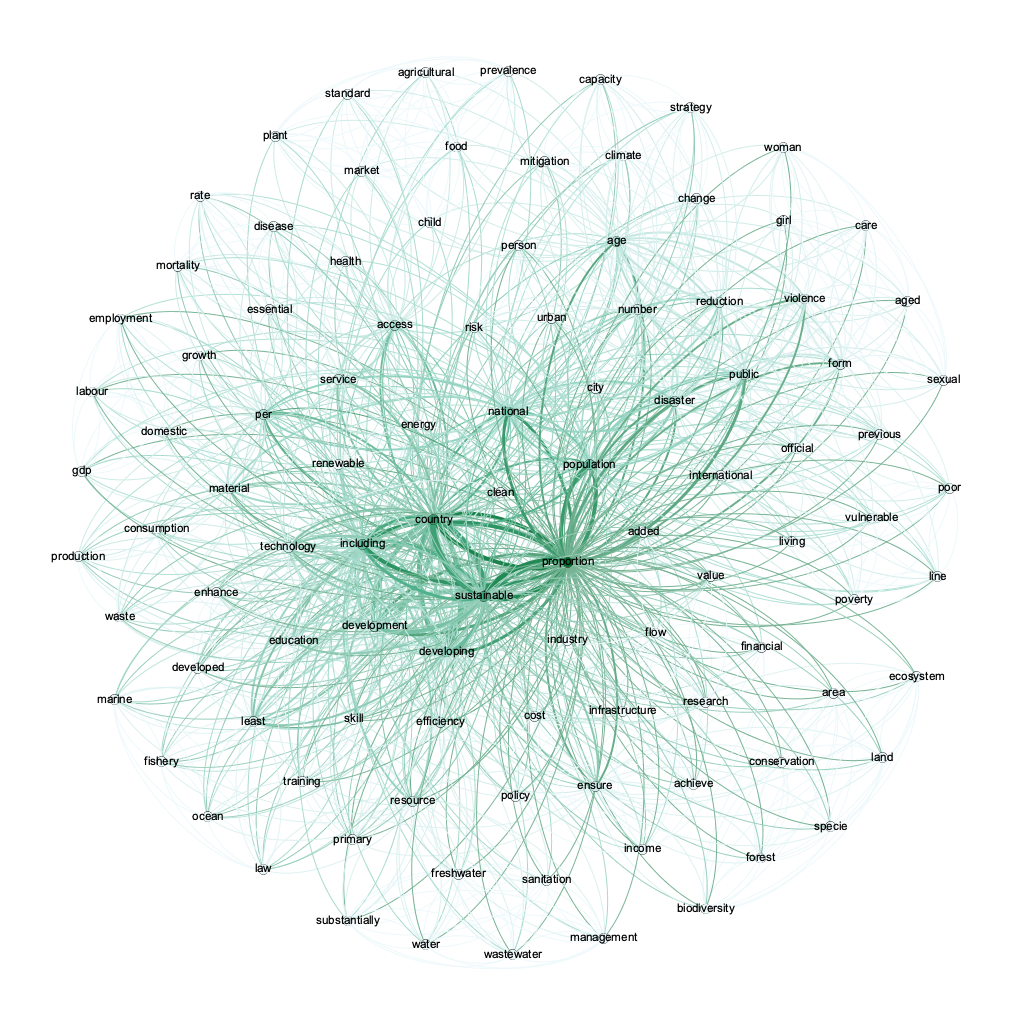

In [53]:
from IPython.display import Image   #to import picture outside Python
Image("Top10SDG.png",width=500, height=100)

We see that there are thematic emphases around the keywords: "proportion", "sustainable",  "country" 
and "population". This does not really surprise since we did not exlcude any words (except of the stopwords) 
from the data. The next step would be to remove meaningless keywords, such as "sustainable" and "country" and 
re-draw the network map. We can do that by simply appending the words we wish to exclude to our dictionary of stopwords:

In [41]:
#keywords to exclude:
porter = PorterStemmer()
wnl = WordNetLemmatizer()
stop = stopwords.words('english')
stop.append("sustainable")
stop.append("proportion")
stop.append("country")
stop.append("development")
stop.append("developing")
stop.append("sustainable")
stop.append("management") 
stop = set(stop)
# .... and so on, we can redraw the net-work with more and less exclusion until we are satisfied

Drawing the Network map after the exclusion gives us:

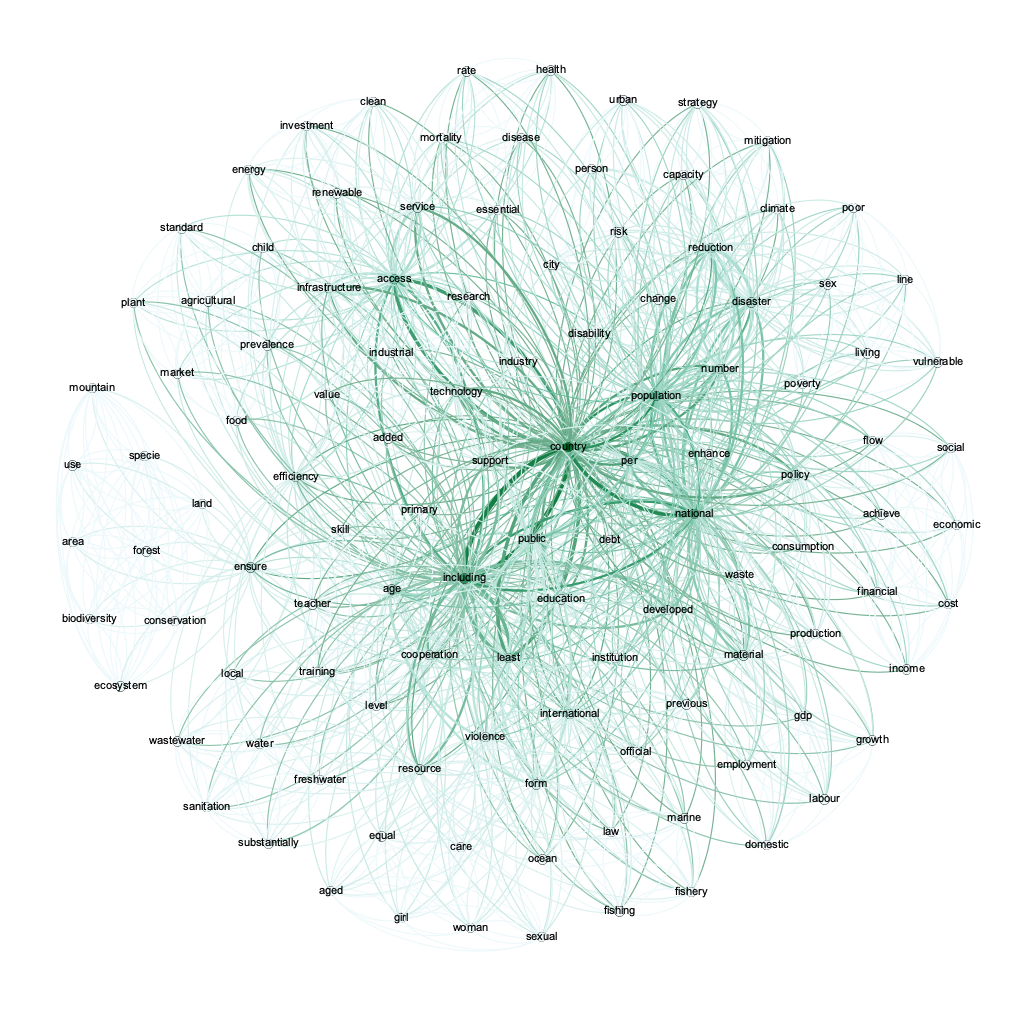

In [50]:
Image("top10ex.png",width=500, height=100)

We see that we still have keywords to exclude, such as "including" or "developed" that do not tell us much.
However, we already gather some insights: "debt", "education", the public sector and cooperation with institutions 
seem to play a significant role for the SDGs. We can look at every nod respecitvely to see the precise connections:
Let's take "waste" and "debt" as an example:

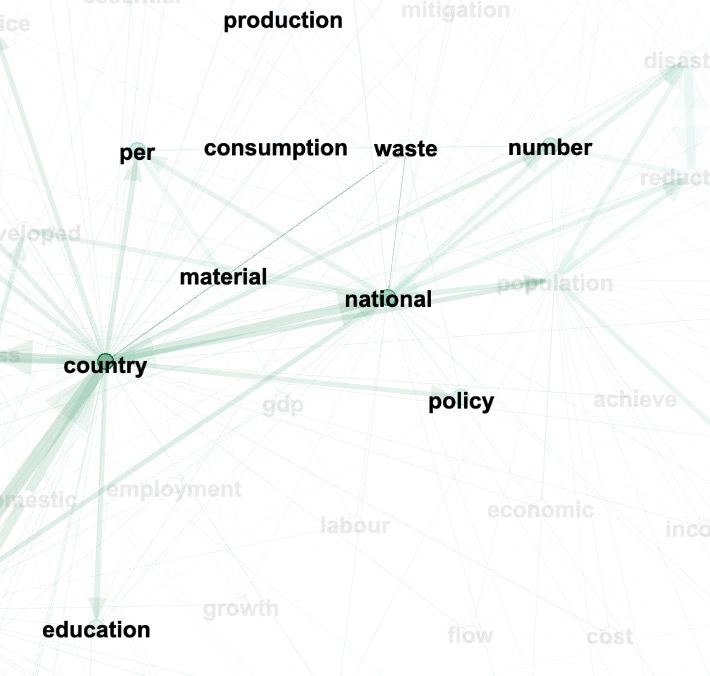

In [57]:
Image("waste.png",width=300, height=100) #Connection from "Waste" node:

This tells us several things: i) waste management is an important topic for the SDGs and it is connected
to production and consumption, but also to education, implying that not only policies (also a connection) 
should play a role in tackling this issue, but also educating the population.

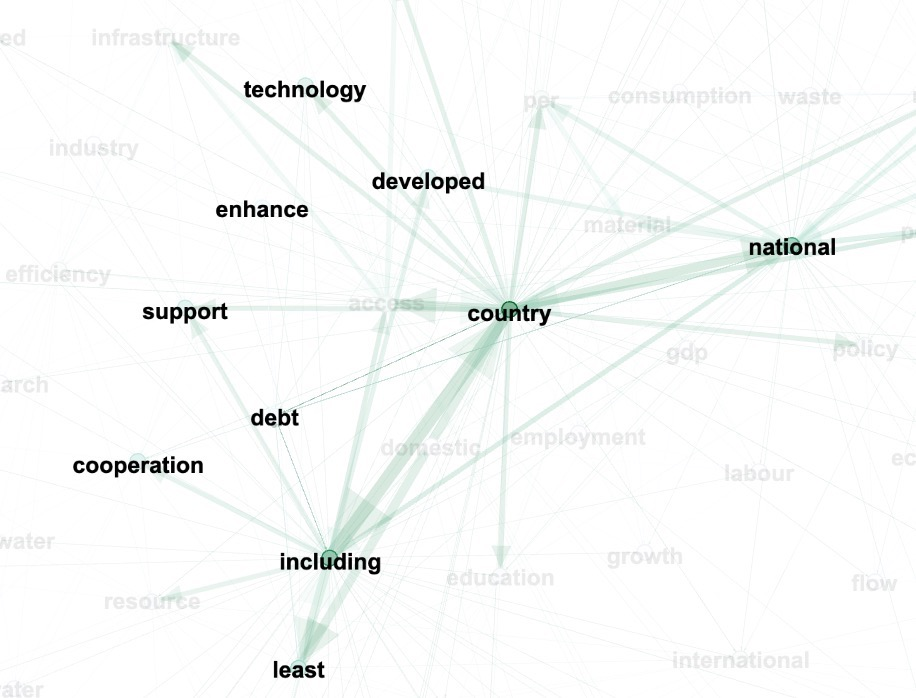

In [58]:
Image("debt.png",width=300, height=100) #Connection from "debt" node:

Looking at "debt", we see that with connections to "cooperation", "support" and "including", financial aid 
plays a role for SDGs strategies. Interestingly, we also see the close linkage to "developed" and "technology" 
indicatind that investment shall flow in technology-heavy sectors to sustain development.

Note, that through this we can already draw linkages between thematic areas of the SDGs using rather basic data exploring techniques. The more interesting question, however, is how we can design our keywords and thematic emphases and gather information from the data about them. In the next step, we move to the design of own keywords: To ensure high quality we suggest to combine both i) sophisticated algorithms that obtain meaningful keywords as well as ii) our expert knowledge and keywords created by us. 

Before moving to the machine learning methods, we work with the keywords we loaded at the beginning. 
For a start, let's define a function that counts the matches and thus artificially clusters the keywords to the SDGs.


In [59]:
res = []
for a in article_df['total']:
    res.append(strip2.applymap(lambda x: str.count(a, x)))
# lambda a in x implies that we look for perfect matches, hence we match "key sentences" as a whole. 
# We can specify this for future analyses, but let's start with the basic mechanism. 

map = pd.concat(res, axis=1).T
map.index = np.arange(len(map))
map.columns = strip2
# calculate correlation matrix
cor = map.corr()
# delete columns with zero matches since we suggest that if a keywords matches not even once it can be excluded.
map = map.loc[:, (map != 0).any(axis=0)]
# save as csv for further visualizations. 
map.to_csv('correlation_mapping.csv')